In [ ]:
!wget https://raw.githubusercontent.com/Esri/arcgis-python-api/master/samples/04_gis_analysts_data_scientists/data/enso_ready.csv

--2021-05-29 17:10:36--  https://raw.githubusercontent.com/Esri/arcgis-python-api/master/samples/04_gis_analysts_data_scientists/data/enso_ready.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24873 (24K) [text/plain]
Saving to: ‘enso_ready.csv.1’

enso_ready.csv.1    100%[===================>]  24.29K  --.-KB/s    in 0.001s  

2021-05-29 17:10:36 (18.5 MB/s) - ‘enso_ready.csv.1’ saved [24873/24873]



In [ ]:
%matplotlib inline
import os.path
import warnings
import numpy as np
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import datetime
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import Conv1D, Conv2D
from keras.layers import MaxPooling1D, MaxPooling2D
import keras
from sklearn.metrics import mean_squared_error as mse

warnings.filterwarnings('ignore')




def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
        return datetime.strptime(x, '%Y0%m')
enso_ready_path = 'enso_ready.csv'
df = read_csv(enso_ready_path, header=0, parse_dates=[0], index_col=0, date_parser=parser)
df.head()


,soi,oni,nino3,pna,precip
date,,,,,
1951-01-01,1.5,-0.8,-0.72,-1.18,NaN
1951-02-01,0.9,-0.5,-0.43,-2.11,NaN
1951-03-01,-0.1,-0.2,-0.63,-1.09,NaN
1951-04-01,-0.3,0.2,0.00,0.47,NaN
1951-05-01,-0.7,0.4,-0.12,1.19,NaN


In [ ]:
df.tail(12)

,soi,oni,nino3,pna,precip
date,,,,,
2016-09-01,1.2,-0.7,-0.19,0.11,-1.21
2016-10-01,-0.3,-0.7,-0.52,1.53,-0.66
2016-11-01,-0.1,-0.7,-0.48,1.44,-2.07
2016-12-01,0.3,-0.6,-0.48,-0.65,-4.17
2017-01-01,0.2,-0.3,-0.09,-0.29,-4.38
2017-02-01,-0.1,-0.1,0.40,-0.05,-4.56
2017-03-01,0.9,0.1,0.24,-0.03,-4.32
2017-04-01,-0.2,0.3,0.42,0.14,-0.80
2017-05-01,0.3,0.4,0.31,-0.19,0.56


In [ ]:
df.precip = df.precip.fillna(df.precip.mean())

In [ ]:
df_main = df.drop(['soi', 'nino3', 'pna', 'precip'], axis=1)
df_main

,oni
date,
1951-01-01,-0.8
1951-02-01,-0.5
1951-03-01,-0.2
1951-04-01,0.2
1951-05-01,0.4
...,...
2017-04-01,0.3
2017-05-01,0.4
2017-06-01,0.4


In [ ]:
df_main.to_csv('oni_source.csv')

In [ ]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
# oni

dataset = df_main.oni.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) - 16)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
        
look_back = 3
    
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(780, 12, 780, 12)

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=50, batch_size=5, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

model.summary()

Epoch 1/50
156/156 [==============================] - 3s 8ms/step - loss: 0.1206 - val_loss: 0.0057
Epoch 2/50
156/156 [==============================] - 1s 3ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 3/50
156/156 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 4/50
156/156 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 5/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 6/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 7/50
156/156 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 8/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 9/50
156/156 [==============================] - 1s 4ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 10/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0017

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)
Y_test = scaler.inverse_transform([Y_test])

In [ ]:
df_main.mean()

oni    0.041
dtype: float64

In [ ]:
Y_test[0]

array([-0.60000011, -0.70000008, -0.70000008, -0.70000008, -0.60000011,
       -0.30000005, -0.09999997,  0.09999997,  0.29999992,  0.39999989,
        0.39999989,  0.09999997])

In [ ]:
res = 0
for i in range(len(preds)):
    res += abs(preds[i] - Y_test[0][i])
res /= len(preds)
res

array([0.08142991], dtype=float32)

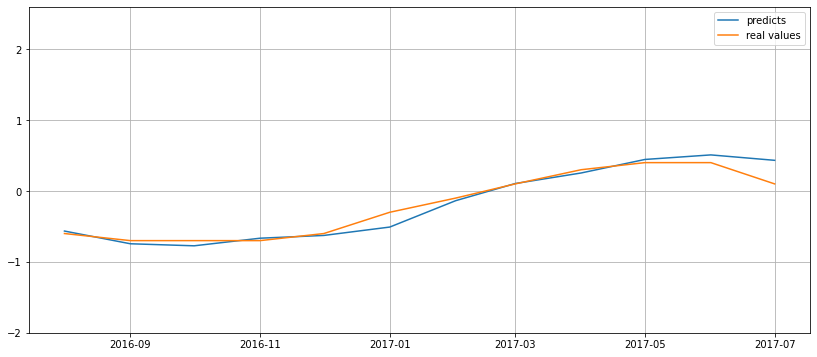

In [ ]:
plt.figure(figsize=(14, 6))
plt.ylim(min(df_main.oni), max(df_main.oni))
plt.grid()
plt.plot( list(df_main.tail(13).index)[:12], preds, label='predicts')
plt.plot( list(df_main.tail(13).index)[:12], Y_test[0], label='real values')
plt.legend()
plt.savefig('foo.png')



In [ ]:
res = 0
for i range(len(preds)):


In [ ]:
Y_test

array([[-0.60000011, -0.70000008, -0.70000008, -0.70000008, -0.60000011,
        -0.30000005, -0.09999997,  0.09999997,  0.29999992,  0.39999989,
         0.39999989,  0.09999997]])

In [ ]:
for i in range(len(Y_test[0])):
    print(preds[i], ' - ', Y_test[0][i], ' - ', df_main.tail(13).oni[i], df_main.tail(13).index[i])

[-0.56346107]  -  -0.6000001096725425  -  -0.6 2016-08-01 00:00:00
[-0.73684376]  -  -0.7000000822544068  -  -0.7 2016-09-01 00:00:00
[-0.7583034]  -  -0.7000000822544068  -  -0.7 2016-10-01 00:00:00
[-0.6429743]  -  -0.7000000822544068  -  -0.7 2016-11-01 00:00:00
[-0.60152936]  -  -0.6000001096725425  -  -0.6 2016-12-01 00:00:00
[-0.48072547]  -  -0.30000005483627123  -  -0.3 2017-01-01 00:00:00
[-0.1026132]  -  -0.09999997258186438  -  -0.1 2017-02-01 00:00:00
[0.13754965]  -  0.09999997258186438  -  0.1 2017-03-01 00:00:00
[0.2816816]  -  0.29999991774559315  -  0.3 2017-04-01 00:00:00
[0.4698369]  -  0.39999989032745753  -  0.4 2017-05-01 00:00:00
[0.5295651]  -  0.39999989032745753  -  0.4 2017-06-01 00:00:00
[0.448309]  -  0.09999997258186438  -  0.1 2017-07-01 00:00:00


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.11914825295477782
Train Root Mean Squared Error: 0.14825739074839592
Test Mean Absolute Error: 0.0818071116507046
Test Root Mean Squared Error: 0.12449601531522435


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/My Drive/models/oni' )

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/oni/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/models/oni/assets


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 1951-01-01 to 2017-08-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   soi     800 non-null    float64
 1   oni     800 non-null    float64
 2   nino3   800 non-null    float64
 3   pna     800 non-null    float64
 4   precip  800 non-null    float64
dtypes: float64(5)
memory usage: 37.5 KB


In [ ]:
df_main_soi = df.drop(['oni', 'nino3', 'pna', 'precip'], axis=1)
df_main_soi

,soi
date,
1951-01-01,1.5
1951-02-01,0.9
1951-03-01,-0.1
1951-04-01,-0.3
1951-05-01,-0.7
...,...
2017-04-01,-0.2
2017-05-01,0.3
2017-06-01,-0.4


In [ ]:
# soi

dataset_soi = df_main_soi.soi.values
dataset_soi = dataset_soi.astype('float32')
dataset_soi = np.reshape(dataset_soi, (-1, 1))
scaler_soi = MinMaxScaler(feature_range=(0, 1))
dataset_soi = scaler_soi.fit_transform(dataset_soi)
train_size_soi = int(len(dataset_soi) - 16)
test_size_soi = len(dataset_soi) - train_size_soi
train_soi, test_soi = dataset_soi[0:train_size_soi,:], dataset_soi[train_size_soi:len(dataset_soi),:]
    
X_train_soi, Y_train_soi = create_dataset(train_soi, look_back)
X_test_soi, Y_test_soi = create_dataset(test_soi, look_back)

# reshape input to be [samples, time steps, features]
X_train_soi = np.reshape(X_train_soi, (X_train_soi.shape[0], 1, X_train_soi.shape[1]))
X_test_soi = np.reshape(X_test_soi, (X_test_soi.shape[0], 1, X_test_soi.shape[1]))

In [ ]:
len(X_train_soi), len(X_test_soi), len(Y_train_soi), len(Y_test_soi)

(780, 12, 780, 12)

In [ ]:
model_soi = Sequential()
model_soi.add(LSTM(units=100, input_shape=(X_train_soi.shape[1], X_train_soi.shape[2]), return_sequences=True))
model_soi.add(Dropout(0.2))
#model_soi.add(Dense(50))
model_soi.add(LSTM(units=50))
model_soi.add(Dropout(0.2))
model_soi.add(Dense(1))
model_soi.compile(loss='mean_squared_error', optimizer='adam')

history = model_soi.fit(X_train_soi, Y_train_soi, epochs=50, batch_size=5, validation_data=(X_test_soi, Y_test_soi), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

model_soi.summary()

Epoch 1/50
156/156 [==============================] - 5s 9ms/step - loss: 0.1338 - val_loss: 0.0074
Epoch 2/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0076
Epoch 3/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0144 - val_loss: 0.0079
Epoch 4/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0078
Epoch 5/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0079
Epoch 6/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0084
Epoch 7/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0137 - val_loss: 0.0083
Epoch 8/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0083
Epoch 9/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0081
Epoch 10/50
156/156 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0081

In [ ]:
preds_soi = model_soi.predict(X_test_soi)
preds_soi = scaler_soi.inverse_transform(preds_soi)
Y_test_soi = scaler_soi.inverse_transform([Y_test_soi])

In [ ]:
res_soi = 0
for i in range(len(preds_soi)):
    res_soi += abs(preds_soi[i] - Y_test_soi[0][i])
res_soi /= len(preds_soi)
res_soi

array([0.5177106], dtype=float32)

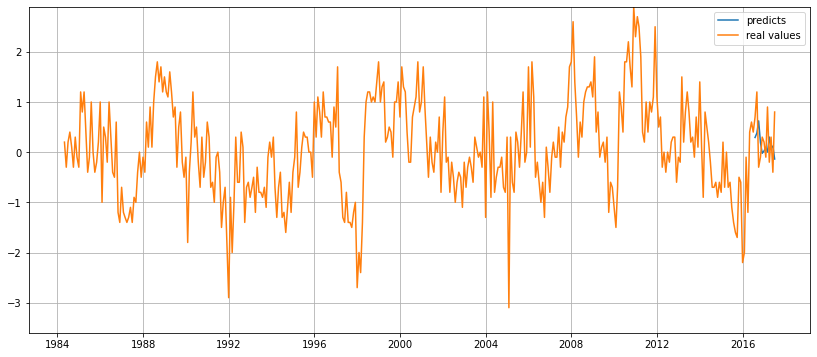

In [ ]:
plt.figure(figsize=(14, 6))
plt.ylim(min(df_main_soi.soi), max(df_main_soi.soi))
plt.grid()
plt.plot( list(df_main_soi.tail(13).index)[:12], preds_soi, label='predicts')
plt.plot( list(df_main_soi.tail(400).index)[:399], df_main_soi.tail(400).soi[:399], label='real values')
plt.legend()
#plt.savefig('soi.png')



In [ ]:
train_predict_soi = model_soi.predict(X_train_soi)
test_predict_soi = model_soi.predict(X_test_soi)
# invert predictions
train_predict_soi = scaler_soi.inverse_transform(train_predict_soi)
#Y_train_soi = scaler_soi.inverse_transform([Y_train_soi])
test_predict_soi = scaler_soi.inverse_transform(test_predict_soi)
#Y_test_soi = scaler_soi.inverse_transform([Y_test_soi])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_soi[0], train_predict_soi[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_soi[0], train_predict_soi[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_soi[0], test_predict_soi[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_soi[0], test_predict_soi[:,0])))

TypeError: ignored

In [ ]:
df_main.head()

,oni
date,
1951-01-01,-0.8
1951-02-01,-0.5
1951-03-01,-0.2
1951-04-01,0.2
1951-05-01,0.4


In [ ]:
# oni

dataset = df_main.oni.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.80)
val_size = int(len(dataset) * 0.05)
test_size = len(dataset) - train_size - val_size

train, val, test = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]

print(len(train), len(val), len(test))
    
X_train, Y_train = create_dataset(train, look_back)
X_val, Y_val = create_dataset(val, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

640 40 120


In [ ]:
len(X_train), len(X_test), len(X_val), len(Y_train), len(Y_test), len(Y_val)

(615, 95, 15, 615, 95, 15)

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=50, batch_size=5, validation_data=(X_val, Y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

model.summary()

Epoch 1/50
123/123 [==============================] - 3s 8ms/step - loss: 0.0668 - val_loss: 0.0142
Epoch 2/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0127 - val_loss: 0.0114
Epoch 3/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0089 - val_loss: 0.0110
Epoch 4/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 5/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 6/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 7/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 8/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 9/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 10/50
123/123 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0033

In [ ]:
x_tess_pred = X_test[0].tolist()[0]

In [ ]:
for x in range(95):
    y_pred = model.predict(np.array([[x_tess_pred]]))
    #print(y_pred)
    x_tess_pred.pop(0) 
    #print(y_pred[0].tolist()[0])
    x_tess_pred.append(y_pred[0].tolist()[0])
    #print(x_tess_pred)
print(len(x_tess_pred))
    


24


In [ ]:
len(Y_test)

95

In [ ]:
x_tess_pred[-15::], Y_test

([0.5215651392936707,
  0.5740693211555481,
  0.6270055174827576,
  0.6788964867591858,
  0.7278887033462524,
  0.7721589803695679,
  0.8095840811729431,
  0.8380162119865417,
  0.8553107976913452,
  0.859291672706604,
  0.8482623100280762,
  0.8212060928344727,
  0.7782422304153442,
  0.7209773063659668,
  0.6524238586425781],
 array([0.54347825, 0.43478262, 0.36956522, 0.3043478 , 0.2826087 ,
        0.2826087 , 0.2826087 , 0.3043478 , 0.36956522, 0.4130435 ,
        0.45652175, 0.5       , 0.5217391 , 0.5217391 , 0.45652175],
       dtype=float32))

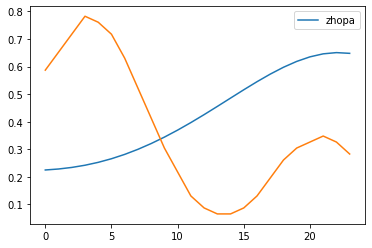

In [ ]:
plt.plot(x_tess_pred)
plt.plot(Y_test[:24])

plt.legend()


In [ ]:
print(np.sqrt(mean_squared_error(Y_test[:24], x_tess_pred)))

0.36241712617413196


In [ ]:
x_tess_pred = scaler.inverse_transform([x_tess_pred])
x_tess_pred

array([[ 0.30275681, -0.3662664 , -0.90380375, -1.28545213, -1.52867814,
        -1.6631597 , -1.71730547, -1.70889165, -1.64470874, -1.54781497,
        -1.43015785, -1.32222766, -1.23248399, -1.16983273, -1.14188721,
        -1.13593637, -1.1465718 , -1.16275871, -1.17134731, -1.17141818,
        -1.15115988, -1.10662954, -1.03341421, -0.92908203]])

In [ ]:
Y_test

array([0.54347825, 0.43478262, 0.36956522, 0.3043478 , 0.2826087 ,
       0.2826087 , 0.2826087 , 0.3043478 , 0.36956522, 0.4130435 ,
       0.45652175, 0.5       , 0.5217391 , 0.5217391 , 0.45652175],
      dtype=float32)

In [ ]:
len(x_tess_pred[0]), len(Y_test)

(24, 15)

In [ ]:
x_tess_pred, Y_test

(array([[ 1.80000005,  2.09999997,  2.40000016,  2.49999986,  2.59999984,
          2.49999986,  2.19999995,  1.70000008,  1.        ,  0.30275681,
         -0.3662664 , -0.90380375, -1.28545213, -1.52867814, -1.6631597 ,
         -1.71730547, -1.70889165, -1.64470874, -1.54781497, -1.43015785,
         -1.32222766, -1.23248399, -1.16983273, -1.14188721]]),
 array([0.54347825, 0.43478262, 0.36956522, 0.3043478 , 0.2826087 ,
        0.2826087 , 0.2826087 , 0.3043478 , 0.36956522, 0.4130435 ,
        0.45652175, 0.5       , 0.5217391 , 0.5217391 , 0.45652175],
       dtype=float32))

ValueError: ignored

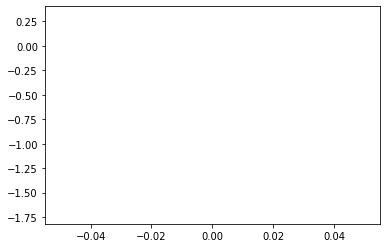

In [ ]:
plt.plot([i for i in range(len(x_tess_pred))], x_tess_pred)
plt.plot([i for i in range(len(x_tess_pred))], Y_test)

In [ ]:
Y_pred = []

for i in range(len(Y_test)):
    Y_pred.append(model.predict(X_test[i]))
    

array([[0.5005994 ],
       [0.3935316 ],
       [0.3138173 ],
       [0.27386576],
       [0.23538464],
       [0.22581369],
       [0.24056536],
       [0.25640693],
       [0.28954455],
       [0.36081943],
       [0.4140237 ],
       [0.4516905 ],
       [0.48483345],
       [0.49656007],
       [0.48163977]], dtype=float32)

In [ ]:
!wget https://raw.githubusercontent.com/Esri/arcgis-python-api/master/samples/04_gis_analysts_data_scientists/data/enso_ready.csv

--2021-05-29 07:46:11--  https://raw.githubusercontent.com/Esri/arcgis-python-api/master/samples/04_gis_analysts_data_scientists/data/enso_ready.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24873 (24K) [text/plain]
Saving to: ‘enso_ready.csv.1’

enso_ready.csv.1    100%[===================>]  24.29K  --.-KB/s    in 0.001s  

2021-05-29 07:46:11 (45.6 MB/s) - ‘enso_ready.csv.1’ saved [24873/24873]



In [ ]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
%matplotlib inline
import os.path
import warnings
import numpy as np
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import datetime
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import Conv1D, Conv2D
from keras.layers import MaxPooling1D, MaxPooling2D
import keras
from sklearn.metrics import mean_squared_error as mse

warnings.filterwarnings('ignore')

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
        


def train_predict_model_oni(df):
    # oni
    dataset = df.oni.values
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) - 16)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    look_back = 3
        
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    #train model
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(X_train, Y_train, epochs=50, batch_size=5, validation_data=(X_test, Y_test), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                        verbose=1, shuffle=False)

    model.summary()

    #make predicts
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds)
    Y_test = scaler.inverse_transform([Y_test])

    return preds, Y_test[0]


def train_predict_model_soi(df):
    # oni
    dataset = df.soi.values
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) - 16)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    look_back = 3
        
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    print(X_test)
    
    #train model
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(X_train, Y_train, epochs=50, batch_size=5, validation_data=(X_test, Y_test), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                        verbose=1, shuffle=False)

    model.summary()

    #make predicts
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds)
    Y_test = scaler.inverse_transform([Y_test])

    return preds, Y_test[0]

In [ ]:
preds

NameError: ignored

In [ ]:
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

NameError: ignored

In [ ]:
prds, y_tst = train_predict_model_oni(df_main)

Epoch 1/50
156/156 [==============================] - 3s 8ms/step - loss: 0.0851 - val_loss: 0.0056
Epoch 2/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0051
Epoch 3/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 4/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 5/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 6/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 7/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 8/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 9/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 10/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0015

In [ ]:
prds, y_tst

(array([[-0.53864586],
        [-0.72239935],
        [-0.7430962 ],
        [-0.63263977],
        [-0.5941148 ],
        [-0.47065696],
        [-0.08868095],
        [ 0.14651237],
        [ 0.29553542],
        [ 0.4855305 ],
        [ 0.5443613 ],
        [ 0.46452683]], dtype=float32),
 array([-0.60000011, -0.70000008, -0.70000008, -0.70000008, -0.60000011,
        -0.30000005, -0.09999997,  0.09999997,  0.29999992,  0.39999989,
         0.39999989,  0.09999997]))

In [ ]:
X_test

NameError: ignored

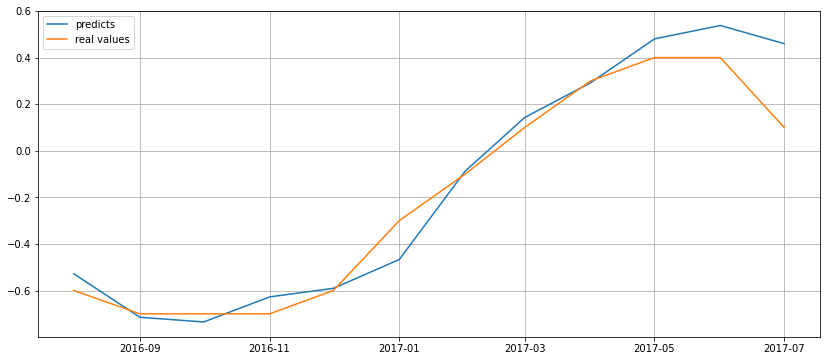

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.grid()
plt.plot( list(df_main.tail(13).index)[:12], prds, label='predicts')
plt.plot( list(df_main.tail(13).index)[:12], y_tst, label='real values')
plt.legend()
plt.savefig('foo.png')

In [ ]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)
Y_test = scaler.inverse_transform([Y_test])

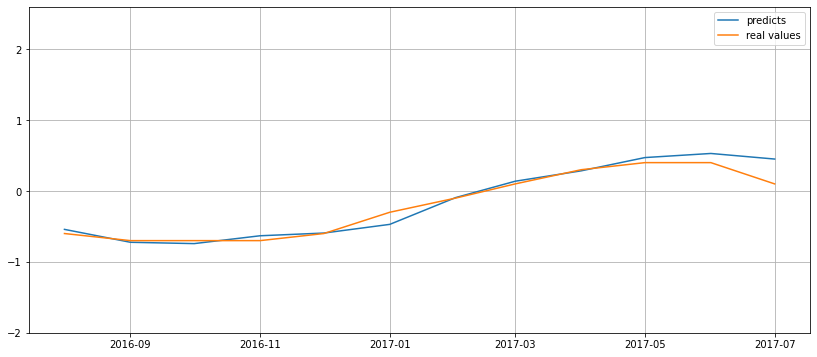

In [ ]:
plt.figure(figsize=(14, 6))
plt.ylim(min(df_main.oni), max(df_main.oni))
plt.grid()
plt.plot( list(df_main.tail(13).index)[:12], preds, label='predicts')
plt.plot( list(df_main.tail(13).index)[:12], Y_test[0], label='real values')
plt.legend()
plt.savefig('foo.png')



In [ ]:
Y_test

array([[-0.60000011, -0.70000008, -0.70000008, -0.70000008, -0.60000011,
        -0.30000005, -0.09999997,  0.09999997,  0.29999992,  0.39999989,
         0.39999989,  0.09999997]])

In [ ]:
for i in range(len(Y_test[0])):
    print(preds[i], ' - ', Y_test[0][i], ' - ', df_main.tail(13).oni[i], df_main.tail(13).index[i])

[-0.54141825]  -  -0.6000001096725425  -  -0.6 2016-08-01 00:00:00
[-0.7232559]  -  -0.7000000822544068  -  -0.7 2016-09-01 00:00:00
[-0.74204797]  -  -0.7000000822544068  -  -0.7 2016-10-01 00:00:00
[-0.63151014]  -  -0.7000000822544068  -  -0.7 2016-11-01 00:00:00
[-0.59319985]  -  -0.6000001096725425  -  -0.6 2016-12-01 00:00:00
[-0.47070113]  -  -0.30000005483627123  -  -0.3 2017-01-01 00:00:00
[-0.09287852]  -  -0.09999997258186438  -  -0.1 2017-02-01 00:00:00
[0.1377934]  -  0.09999997258186438  -  0.1 2017-03-01 00:00:00
[0.2842009]  -  0.29999991774559315  -  0.3 2017-04-01 00:00:00
[0.47138217]  -  0.39999989032745753  -  0.4 2017-05-01 00:00:00
[0.52920264]  -  0.39999989032745753  -  0.4 2017-06-01 00:00:00
[0.45050958]  -  0.09999997258186438  -  0.1 2017-07-01 00:00:00


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.11914825295477782
Train Root Mean Squared Error: 0.14825739074839592
Test Mean Absolute Error: 0.0818071116507046
Test Root Mean Squared Error: 0.12449601531522435


In [ ]:
df.precip = df.precip.fillna(df.precip.mean())

In [ ]:
df_main = df.drop(['soi', 'nino3', 'pna', 'precip'], axis=1)
df_main

,oni
date,
1951-01-01,-0.8
1951-02-01,-0.5
1951-03-01,-0.2
1951-04-01,0.2
1951-05-01,0.4
...,...
2017-04-01,0.3
2017-05-01,0.4
2017-06-01,0.4


In [ ]:
data = np.array([[[float(v) for v in scaler.transform(df_main[-25:-1].values)]]])
data

array([[[0.82608699, 0.89130438, 0.95652177, 0.9782609 , 1.00000004,
         0.9782609 , 0.91304351, 0.80434785, 0.65217394, 0.54347828,
         0.43478262, 0.36956523, 0.30434784, 0.28260871, 0.28260871,
         0.28260871, 0.30434784, 0.36956523, 0.41304349, 0.45652176,
         0.50000002, 0.52173915, 0.52173915, 0.45652176]]])

In [ ]:
scaler.transform([[0.6]])

array([[0.56521741]])

In [ ]:
model.predict(data)

array([[0.40940845]], dtype=float32)

In [ ]:
df_main.tail(10)

,oni
date,
2016-11-01,-0.7
2016-12-01,-0.6
2017-01-01,-0.3
2017-02-01,-0.1
2017-03-01,0.1
2017-04-01,0.3
2017-05-01,0.4
2017-06-01,0.4
2017-07-01,0.1


In [ ]:
data = df_main.tail(24).values
data = data.astype('float32')
data = scaler.transform(data)
data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
data

array([[[0.8913044 ]],

       [[0.9565218 ]],

       [[0.9782609 ]],

       [[1.        ]],

       [[0.9782609 ]],

       [[0.9130435 ]],

       [[0.8043479 ]],

       [[0.65217394]],

       [[0.54347825]],

       [[0.43478262]],

       [[0.36956522]],

       [[0.3043478 ]],

       [[0.2826087 ]],

       [[0.2826087 ]],

       [[0.2826087 ]],

       [[0.3043478 ]],

       [[0.36956522]],

       [[0.4130435 ]],

       [[0.45652175]],

       [[0.5       ]],

       [[0.5217391 ]],

       [[0.5217391 ]],

       [[0.45652175]],

       [[0.4130435 ]]], dtype=float32)

In [ ]:
model.predict(data)

ValueError: ignored

In [ ]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(615, 135, 615, 135)

In [ ]:
Y_test

array([0.3043478 , 0.36956522, 0.4130435 , 0.45652175, 0.5       ],
      dtype=float32)

In [ ]:
Y_test

array([0.13043478, 0.19565217, 0.26086956, 0.3043478 , 0.32608697,
       0.3478261 , 0.32608697, 0.2826087 , 0.23913045, 0.19565217,
       0.19565217, 0.21739131, 0.26086956, 0.3043478 , 0.32608697,
       0.3478261 , 0.39130437, 0.45652175, 0.5       , 0.5       ,
       0.5       , 0.47826087, 0.43478262, 0.39130437, 0.3478261 ,
       0.36956522, 0.39130437, 0.39130437, 0.36956522, 0.36956522,
       0.3478261 , 0.3478261 , 0.36956522, 0.39130437, 0.39130437,
       0.36956522, 0.3478261 , 0.3478261 , 0.39130437, 0.45652175,
       0.5       , 0.47826087, 0.45652175, 0.43478262, 0.47826087,
       0.5217391 , 0.56521744, 0.58695656, 0.56521744, 0.56521744,
       0.56521744, 0.6086957 , 0.65217394, 0.69565225, 0.7608696 ,
       0.826087  , 0.8913044 , 0.9565218 , 0.9782609 , 1.        ,
       0.9782609 , 0.9130435 , 0.8043479 , 0.65217394, 0.54347825,
       0.43478262, 0.36956522, 0.3043478 , 0.2826087 , 0.2826087 ,
       0.2826087 , 0.3043478 , 0.36956522, 0.4130435 , 0.45652

In [ ]:
X_test

array([[[0.06521738, 0.06521738, 0.08695653]],

       [[0.06521738, 0.08695653, 0.13043478]],

       [[0.08695653, 0.13043478, 0.19565217]],

       [[0.13043478, 0.19565217, 0.26086956]],

       [[0.19565217, 0.26086956, 0.3043478 ]],

       [[0.26086956, 0.3043478 , 0.32608697]],

       [[0.3043478 , 0.32608697, 0.3478261 ]],

       [[0.32608697, 0.3478261 , 0.32608697]],

       [[0.3478261 , 0.32608697, 0.2826087 ]],

       [[0.32608697, 0.2826087 , 0.23913045]],

       [[0.2826087 , 0.23913045, 0.19565217]],

       [[0.23913045, 0.19565217, 0.19565217]],

       [[0.19565217, 0.19565217, 0.21739131]],

       [[0.19565217, 0.21739131, 0.26086956]],

       [[0.21739131, 0.26086956, 0.3043478 ]],

       [[0.26086956, 0.3043478 , 0.32608697]],

       [[0.3043478 , 0.32608697, 0.3478261 ]],

       [[0.32608697, 0.3478261 , 0.39130437]],

       [[0.3478261 , 0.39130437, 0.45652175]],

       [[0.39130437, 0.45652175, 0.5       ]],

       [[0.45652175, 0.5       , 0.5    

In [ ]:
df_valid.values

array([[ 0.4],
       [ 0.1],
       [-0.1]])

In [ ]:
X_test = scaler.transform(df_valid.values)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_test
#model.predict(X_test)

array([[[0.52173915]],

       [[0.45652176]],

       [[0.41304349]]])

In [ ]:
df_train = df[:-24]
df_test = df[-24::]

In [ ]:
X = np.array(df_train.drop(['oni'], axis=1))
y = np.array(df_train['oni'])

print(len(X), len(y))

776 776


In [ ]:
X[0]

array([ 1.5       , -0.72      , -1.18      ,  0.00693966])

In [ ]:
df_train.iloc[0]

soi       1.50000
oni      -0.80000
nino3    -0.72000
pna      -1.18000
precip    0.00694
Name: 1951-01-01 00:00:00, dtype: float64

In [ ]:
X.shape, y.shape

((776, 4), (776,))

In [ ]:
X = np.array(X).reshape(X.shape[0], X.shape[1], 1)
X

array([[[ 1.50000000e+00],
        [-7.20000000e-01],
        [-1.18000000e+00],
        [ 6.93965517e-03]],

       [[ 9.00000000e-01],
        [-4.30000000e-01],
        [-2.11000000e+00],
        [ 6.93965517e-03]],

       [[-1.00000000e-01],
        [-6.30000000e-01],
        [-1.09000000e+00],
        [ 6.93965517e-03]],

       ...,

       [[-6.00000000e-01],
        [ 1.54000000e+00],
        [-7.00000000e-02],
        [ 3.90000000e-01]],

       [[-1.10000000e+00],
        [ 1.87000000e+00],
        [ 2.90000000e-01],
        [ 1.02000000e+00]],

       [[-1.40000000e+00],
        [ 2.08000000e+00],
        [ 5.00000000e-02],
        [ 7.39000000e+00]]])

In [ ]:
X_test = np.array(df_test.drop(['oni'], axis=1))
y_test = np.array(df_test['oni'])

X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

print(len(X_test), len(y_test))

24 24


In [ ]:
def model_prepered(X):
    model = keras.Sequential()
    model.add(LSTM(50, activation='relu'))
    #model.add(keras.layers.Dense(50, activation= 'tanh'))
    #model.add(keras.layers.Dense(50, activation= 'tanh'))
    #model.add(keras.layers.Dense(50, activation= 'tanh'))
    model.add(keras.layers.Dense(1, name = 'output_layer'))

    model.compile(optimizer='adam', loss='mse')
    input_shape = (X.shape[0], X.shape[1], 1)
    model.build(input_shape) # `input_shape` is the shape of the input data
                            # e.g. input_shape = (None, 32, 32, 3)
    model.summary()

    return model


preds = []
trues = []
preds_last_for_plot = []

for i in range(2, len(X_test)):
    model = model_prepered(X)

    history = model.fit(X, y, epochs=20, batch_size=2)

    pred = model.predict(X_test[i-2:i+1])


    preds.append(pred)
    trues.append(y_test[i-2:i+1])

    np.append(X, X_test[i-2])
    np.append(y, y_test[i-2])
    preds_last_for_plot.append(pred[0])

    

NameError: ignored

In [ ]:
import math
def model_prepered(X):
    model = keras.Sequential()
    model.add(LSTM(50, activation='tanh'))
    #model.add(keras.layers.Dense(50, activation= 'tanh'))
    #model.add(keras.layers.Dense(50, activation= 'tanh'))
    model.add(keras.layers.Dense(50, activation= 'tanh'))
    model.add(keras.layers.Dense(1, name = 'output_layer'))

    model.compile(optimizer='adam', loss='mse')
    input_shape = (X.shape[0], X.shape[1], 1)
    model.build(input_shape) # `input_shape` is the shape of the input data
                            # e.g. input_shape = (None, 32, 32, 3)
    model.summary()

    return model


preds = []
trues = []
model = model_prepered(X)

history = model.fit(X, y, epochs=50, batch_size=2)
preds = model.predict(X_test)

#mses = []

#batches = [2, 5, 8, 12]
#epoches = [20, 50, 60, 70]

#for batch in batches:
    #for epoch in epoches:
        #history = model.fit(X, y, epochs=epoch, batch_size=batch)
        #preds = model.predict(X_test)

        #mses.append([batch, epoch, math.sqrt(mse(y_test, preds))])




    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (776, 50)                 10400     
_________________________________________________________________
dense (Dense)                (776, 50)                 2550      
_________________________________________________________________
output_layer (Dense)         (776, 1)                  51        
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
388/388 [==============================] - 27s 4ms/step - loss: 0.4591
Epoch 2/50
388/388 [==============================] - 1s 4ms/step - loss: 0.2840
Epoch 3/50
388/388 [==============================] - 1s 3ms/step - loss: 0.2106
Epoch 4/50
388/388 [==============================] - 1s 3ms/step - loss: 0.1939
Epoch 5/50
388/388 [==============================] - 1s 

mse = 0.16780074082703647
rmse = 0.4096348872191387


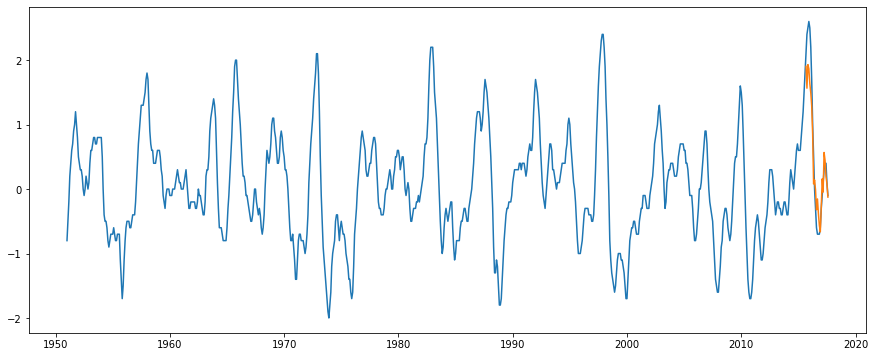

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import math
import matplotlib.pyplot as plt 

print("mse = {}".format(mse(y_test, preds)))
print("rmse = {}".format(math.sqrt(mse(y_test, preds))))

plt.figure(figsize=(15, 6))
plt.plot(df.index, df.oni)
plt.plot(df.tail(len(y_test)).index, preds)
plt.show()

In [ ]:
mean = np.mean(y)
ar_days = []
cnt_days = 0
for i in range(len(preds)):
    #print(preds[i] , mean)
    if abs(preds[i] - mean) >= 0.4:
      cnt_days += 1
    else:
      ar_days.append(cnt_days)
      cnt_days = 0
print(cnt_days)
print(ar_days)

0
[8, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0]


In [ ]:
min([el[2] for el in mses])

(0.3250377945803842,
 [[2, 20, 0.3465888875617353],
  [2, 50, 0.3250377945803842],
  [2, 60, 0.3822837911043956],
  [2, 70, 0.3955625719289356],
  [5, 20, 0.37516606653555656],
  [5, 50, 0.3806873507180991],
  [5, 60, 0.41171402804254215],
  [5, 70, 0.4254784847670681],
  [8, 20, 0.42455334491844016],
  [8, 50, 0.42346337910467097],
  [8, 60, 0.4371809115063977],
  [8, 70, 0.453832925976193],
  [12, 20, 0.45658530845991],
  [12, 50, 0.4971946332317551],
  [12, 60, 0.5091970324614216],
  [12, 70, 0.5015555494433465]])

min: 0.30537456712074923


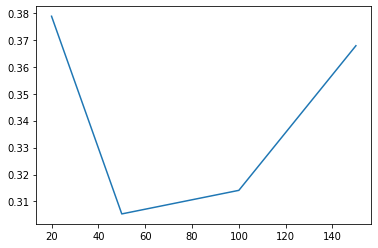

In [ ]:
#epochs

print("min: {}".format(min(mses)))
plt.plot([20, 50, 100, 150], mses)

min: 0.28373404374543587


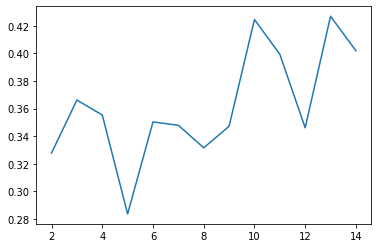

In [ ]:
#batches

print("min: {}".format(min(mses)))
plt.plot([i+2 for i in range(len(mses))], [mses[i] for i in range(len(mses))])

mse = 0.10446155215632881
rmse = 0.3232051239636043


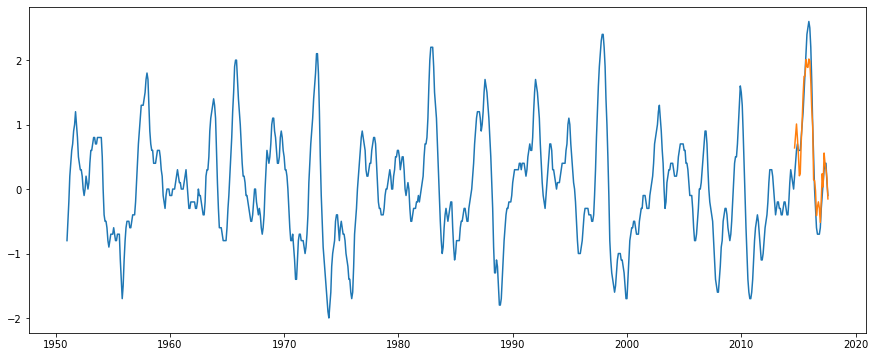

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import math
import matplotlib.pyplot as plt 

print("mse = {}".format(mse(y_test, preds)))
print("rmse = {}".format(math.sqrt(mse(y_test, preds))))

plt.figure(figsize=(15, 6))
plt.plot(df.index, df.oni)
plt.plot(df.tail(36).index, preds)
plt.show()

In [ ]:
np.mean(y)

0.010602094240837693

In [ ]:
from keras.layers import Dropout

nb_out = 1

model = Sequential()

model.add(LSTM(
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='tanh'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#print(model.summary())

# fit the network
history = model.fit(X, y, epochs=50, batch_size=2, validation_split=0.05, verbose=2)




    

Epoch 1/50
363/363 - 33s - loss: 0.3856 - mse: 0.3856 - val_loss: 0.1589 - val_mse: 0.1589
Epoch 2/50
363/363 - 2s - loss: 0.2862 - mse: 0.2862 - val_loss: 0.1746 - val_mse: 0.1746
Epoch 3/50
363/363 - 2s - loss: 0.2536 - mse: 0.2536 - val_loss: 0.1883 - val_mse: 0.1883
Epoch 4/50
363/363 - 2s - loss: 0.2329 - mse: 0.2329 - val_loss: 0.2822 - val_mse: 0.2822
Epoch 5/50
363/363 - 2s - loss: 0.2028 - mse: 0.2028 - val_loss: 0.0956 - val_mse: 0.0956
Epoch 6/50
363/363 - 2s - loss: 0.1843 - mse: 0.1843 - val_loss: 0.1302 - val_mse: 0.1302
Epoch 7/50
363/363 - 2s - loss: 0.1843 - mse: 0.1843 - val_loss: 0.2209 - val_mse: 0.2209
Epoch 8/50
363/363 - 2s - loss: 0.1601 - mse: 0.1601 - val_loss: 0.1697 - val_mse: 0.1697
Epoch 9/50
363/363 - 2s - loss: 0.1602 - mse: 0.1602 - val_loss: 0.1410 - val_mse: 0.1410
Epoch 10/50
363/363 - 2s - loss: 0.1476 - mse: 0.1476 - val_loss: 0.1148 - val_mse: 0.1148
Epoch 11/50
363/363 - 2s - loss: 0.1520 - mse: 0.1520 - val_loss: 0.1759 - val_mse: 0.1759
Epoch 1

mse = 0.41338745520350656
rmse = 0.6429521406788429


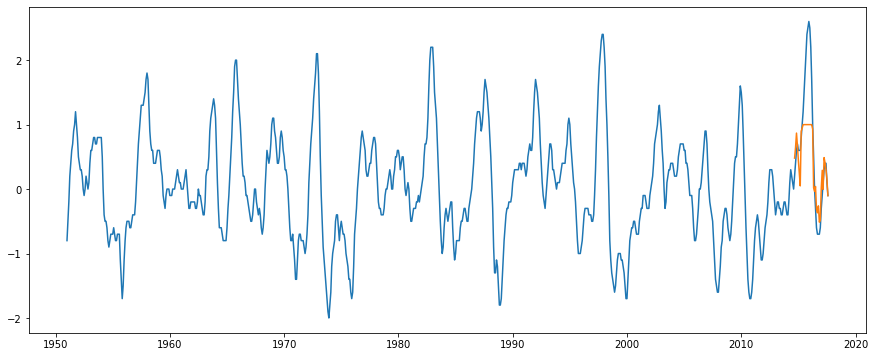

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import math
import matplotlib.pyplot as plt 

preds = model.predict(X_test)

print("mse = {}".format(mse(y_test, preds)))
print("rmse = {}".format(math.sqrt(mse(y_test, preds))))

plt.figure(figsize=(15, 6))
plt.plot(df.index, df.oni)
plt.plot(df.tail(36).index, preds)
plt.show()

In [ ]:
def create_model(X, metric):
    model = Sequential()

    #model.add(LSTM(50, activation='relu'))
    model.add(Conv2D(32, (2,2), padding='same', activation='relu', input_shape=(X.shape[0], X.shape[1], 1)))
    print(1)
    model.add(MaxPooling2D(pool_size=2))
    print(2)
    model.add(keras.layers.Dense(1, name = 'output_layer'))
    print(3)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metric])

    model.fit(X, y, epochs=20, batch_size=2)
    #input_shape = (2, 2, 1)
    #model.build(input_shape)

    #print(model.summary())
    return model 

model = create_model(X, 'mse')


preds = model.predict(X_test)

1
2
3
Epoch 1/20


ValueError: ignored

mse = 0.1529579018698594
rmse = 0.3910983276234499


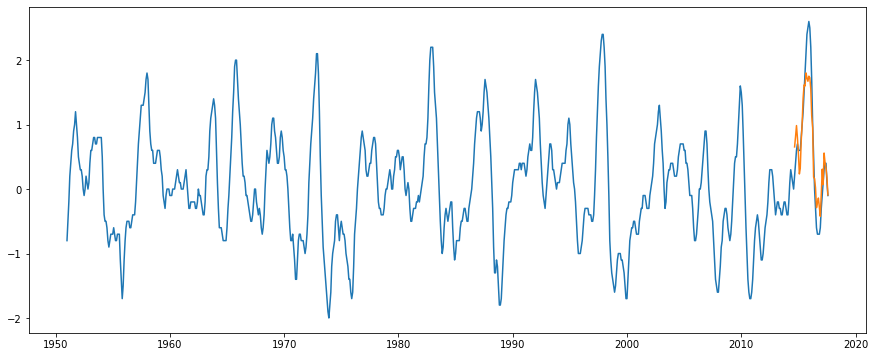

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import math
print("mse = {}".format(mse(y_test, preds)))
print("rmse = {}".format(math.sqrt(mse(y_test, preds))))

plt.figure(figsize=(15, 6))
plt.plot(df.index, df.oni)
plt.plot(df.tail(36).index, preds)
plt.show()

In [ ]:
for i in range(len(preds)):
    print(preds_last_for_plot[i], ' - ', preds[i][0])

[-0.2611115]  -  [-0.2611115]
[-0.30951384]  -  [-0.30951384]
[-0.2696726]  -  [-0.2696726]
[-0.47039276]  -  [-0.47039276]
[-0.28160712]  -  [-0.28160712]
[0.17156503]  -  [0.17156503]
[0.07398054]  -  [0.07398054]
[0.42906958]  -  [0.42906958]
[0.35374746]  -  [0.35374746]
[0.14759935]  -  [0.14759935]


In [ ]:
from sklearn.metrics import mean_squared_error as mse
print(mse(df.tail(10).oni, preds_last_for_plot))

0.08100623570595729


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for i in range(len(preds_last_for_plot)):
    print(preds_last_for_plot[i], ' - ', trues[i][0])
    #print(list(range(3)), preds[i])
    #print(list(range(3)), trues[i])

[-0.2611115]  -  -0.7
[-0.30951384]  -  -0.7
[-0.2696726]  -  -0.7
[-0.47039276]  -  -0.6
[-0.28160712]  -  -0.3
[0.17156503]  -  -0.1
[0.07398054]  -  0.1
[0.42906958]  -  0.3
[0.35374746]  -  0.4
[0.14759935]  -  0.4


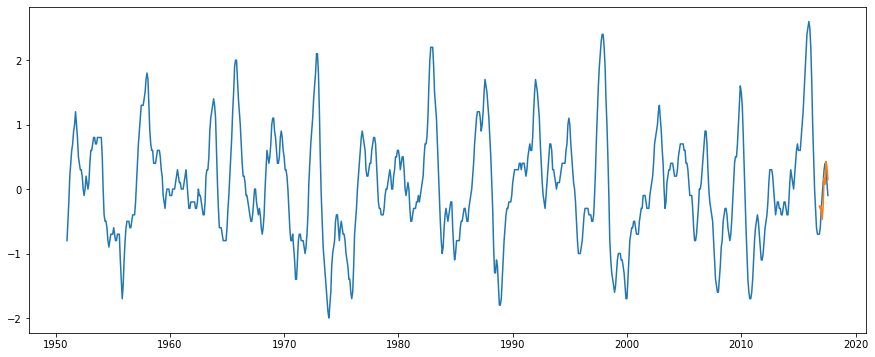

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df.oni)
plt.plot(df.tail(10).index, preds_last_for_plot)
plt.show()

In [ ]:
y_test

array([-0.7, -0.7, -0.7, -0.6, -0.3, -0.1,  0.1,  0.3,  0.4,  0.4,  0.1,
       -0.1])